# Functional landscape based on NICE

This pipeline generates a map of functions from a specific vocabulary for the Interactome.

It bundles together genes in closer regions that have similar functions. 

NICE (network informed enrichment) assigns extra annotation terms to individual genes

by using random walk with restart and providing network context for every gene.

Note, that most of the input data or in-between steps are already pre-computed for specific paramater settings.

Using them the pipline takes less than 10 mins to run. Most time will be spend on calculating the Gene-Gene distance matrix.

Computing everything anew needs considerably more time (~1 hr)


In [1]:
import os
import sys
import numpy as np
import networkx as nx
import itertools as it
import random as rd
import scipy.sparse as sp
import scipy.stats as st
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import fcluster
import math
import urllib
import gzip
import colorsys
import pickle as pk
import os.path
from collections import defaultdict, Counter, ChainMap
import umap
import time
# import statsmodels.sandbox.stats.multicomp as mc
from sklearn.preprocessing import normalize
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import json

import matplotlib.pyplot as plt
# %matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/V

## Functions

In [2]:

def rnd_walk_matrix(G, r, a):

    n = G.number_of_nodes()
    A = nx.adjacency_matrix(G,sorted(G.nodes()))

    factor = float((1-a)/n)

    E = np.multiply(factor,np.ones([n,n]))              # prepare 2nd scaling term
    A_tele = np.multiply(a,A) + E  

#     print(A_tele)
    M = normalize(A_tele, norm='l1', axis=0)                                 # column wise normalized MArkov matrix

    # mixture of Markov chains
    del A_tele
    del E

    U = np.identity(n,dtype=int) 
    H = (1-r)*M
    H1 = np.subtract(U,H)
    del U
    del M
    del H    

    W = r*np.linalg.inv(H1)   

    return W


def fisher_test(sig_level,sampleset,d_sample_attributes,d_attributes_sample,background):
    #####
    # IDENTIFY ALL TERMS TO BE TESTED IN SAMPLE
    #####
    # take only these neighboring genes that come with a disease annotation
    sample_overlap = set(sampleset) & set(d_sample_attributes.keys())
    # sample_overlap = sampleset
    
    l_terms = []
    for gene in sample_overlap:
        for x in d_sample_attributes[gene]:
            l_terms.append(x)
        
    # print('tests :%s ' %len(l_terms))
    # print('set of tests :%s ' %len(set(l_terms)))
    set_terms = set(l_terms)
    number_of_tests = len(set_terms)

    # make a dictionary of all GO terms with their p-values 
    d_term_p = {}

    for term in set_terms:
        attributeset = set(d_attributes_sample[term])

        ab = len(sample_overlap.intersection(attributeset))
        amb = len(sample_overlap.difference(attributeset))
        bma = len(attributeset.difference(sample_overlap))
#         backg = background - len(set(sample_overlap) | set(attributeset))
        backg = background - ab - amb - bma

        # pval = pvalue(ab , amb, bma,backg).right_tail
        oddsratio, pval = st.fisher_exact([[ab, amb], [bma, backg]],alternative='greater')
        d_term_p[term] = pval * number_of_tests
#         print(pval)
        # f.write('%s,%s,%s,%s,%.6f\n' %(ab,amb,bma,backg,pval))
    # f.close()
    return d_term_p 
	

##################################################################
##################################################################

def color_creator(n):

    colors = [colorsys.hsv_to_rgb(1.0/n*x,1,1) for x in range(n)]
    color_list = []
    for c in colors:
        cc = [int(y*255) for y in c]
        color_list.append('#%02x%02x%02x' % (cc[0],cc[1],cc[2]))
        
    return color_list



def make_different_hexcolors(N):
    N_colors = N

    # packing criterium
    d_min_c = 9./5*33554432/np.pi/N

    d_mindistance = d_min_c**(2./3.)
    # print(d_mindistance)

    # init_color = f"#{''.join(np.random.choice(list('0123456789abcdef'), size=6))}" 
    init_col = [rd.randint(0, 255),rd.randint(0, 255),rd.randint(0, 255)]
    # print(init_col)
    l_colors = []
    l_colors.append(init_col)
    # for n in range(1):
    while len(l_colors) < N_colors:
        rd_col = [rd.randint(0, 255),rd.randint(0, 255),rd.randint(0, 255)]
        # print(rd_col)
        l_dists = []
        for c in l_colors:
            d = (rd_col[0] - c[0])**2 + (rd_col[1] - c[1])**2 + (rd_col[2] - c[2])**2

            l_dists.append(d)
        if min(l_dists)>d_mindistance:
            l_colors.append(rd_col)

    l_hexcols = [rgb2hex(rgb[0],rgb[1],rgb[2]) for rgb in l_colors]
    return l_hexcols


def Ginfo(G):
    info = []
    info.append(f"Graph Name: {G.name}")
    info.append(f"Graph Type: {type(G).__name__}")
    info.append(f"Number of Nodes: {G.number_of_nodes()}")
    info.append(f"Number of Edges: {G.number_of_edges()}")
    # info.append(f"Density: {round(100. * nx.density(G), 3)} %")

    # if nx.is_weighted(G):
    #     info.append(f"Weighted: Yes")
        
    #     # Calculate the average degree considering edge weights for weighted graphs
    #     avg_weighted_degree = sum(weight for u, v, weight in G.edges(data=True)) / G.number_of_nodes()
    #     info.append(f"Average Weighted Degree: {round(avg_weighted_degree, 2)}")
    # else:
    #     info.append(f"Weighted: No")
        
    #     # Calculate the average degree as usual for unweighted graphs
    #     avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
    #     info.append(f"Average Degree: {round(avg_degree, 2)}")

    info.append(f"Connected: {'Yes' if nx.is_connected(G) else 'No'}")
    num_components = nx.number_connected_components(G)
    info.append(f"Number of Connected Components: {num_components}")

    info.append(f"Directed: {'Yes' if G.is_directed() else 'No'}")
    
    return "\n".join(info)

### ID mappings

In [3]:


def download_mapping_file(url, filename):
    urllib.request.urlretrieve(url, filename)

def parse_mapping_file(filename):
    mapping = {}
    with gzip.open(filename, 'rt') as file:
        for line in file:
            if line.startswith('#'):  # Skip header and comments
                continue
            fields = line.strip().split('\t')
            if fields[0] == '9606':
                gene_symbol = fields[2]
                entrez_id = fields[1]
                # ensembl_id = fields[5]
                # Additional mapping field
                gene_name = fields[10]
                if gene_symbol not in mapping:
                    mapping[gene_symbol] = {
                        'entrez_id': entrez_id,
                        # 'ensembl_id': ensembl_id,
                        'gene_name': gene_name
                    }
    return mapping


def convert_symbols_to_entrez(gene_symbols, mapping):
    entrez_ids = []
    for symbol in gene_symbols:
        if symbol in mapping:
            entrez_ids.append(mapping[symbol]['entrez_id'])
    return entrez_ids

# def convert_symbols_to_ensembl(gene_symbols, mapping):
#     ensembl_ids = []
#     for symbol in gene_symbols:
#         if symbol in mapping:
#             ensembl_ids.append(mapping[symbol]['ensembl_id'])
#     return ensembl_ids

# Download Gene Info file (example using Homo sapiens)
url = 'ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/GENE_INFO/Mammalia/Homo_sapiens.gene_info.gz'
filename = 'Homo_sapiens.gene_info.gz'
# download_mapping_file(url, filename)

# Parse mapping file
mapping = parse_mapping_file(filename)

# Generate a dictionary of all existing gene symbols and their corresponding Entrez IDs and Ensemble IDs
all_gene_symbols = list(mapping.keys())
all_entrez_ids = [mapping[symbol]['entrez_id'] for symbol in all_gene_symbols]
# all_ensembl_ids = [mapping[symbol]['ensembl_id'] for symbol in all_gene_symbols]
symbol_to_entrez = dict(zip(all_gene_symbols, all_entrez_ids))
# symbol_to_ensembl = dict(zip(all_gene_symbols, all_ensembl_ids))
entrez_to_symbols = {v: k for k, v in symbol_to_entrez.items()}
# ensembl_to_symbols = {v: k for k, v in symbol_to_ensembl.items()}


## load data

In [4]:
path = '/Users/fmueller/work/NICE/GitNICE/Data/'


print('full PPI')
# PPI direct
G_ppi = nx.read_edgelist(path + 'PPIs/PPI_physical_elist.csv',data=False, delimiter=',')
print(Ginfo(G_ppi))
print('\nlcc PPI')

lcc = max(nx.connected_components(G_ppi), key=len)
G = nx.subgraph(G_ppi,lcc)

print(Ginfo(G))

full PPI
Graph Name: 
Graph Type: Graph
Number of Nodes: 18068
Number of Edges: 306914
Connected: No
Number of Connected Components: 2
Directed: No

lcc PPI
Graph Name: 
Graph Type: Graph
Number of Nodes: 18064
Number of Edges: 306911
Connected: Yes
Number of Connected Components: 1
Directed: No


### random walk

Note, you can skip the next two cells and load pre-computed neighborhood for r=0.8

takes ca 5' on local machine

In [5]:
# r = .85
# alpha = 1.

# W = rnd_walk_matrix(G, r, alpha)

# print('Inversion done')

# d_idx_entz = {}
# cc = 0
# for entz in sorted(G.nodes()):
#     d_idx_entz[cc] = entz
#     cc += 1
# d_entz_idx = dict((y,x) for x,y in d_idx_entz.items())   


### iterate through RW operator and write neighborhood file

takes ca 7' on local machine

In [6]:
# ########################################################################
# #
# #    CREATE NEIGHBORHOOD DICTIONARY TO CHECK 
# #    FOR AMBIGUITY OF NEIGHBORS
# #
# ###################

# t0 = time.time()


# coverage = .95
# d_node_neighbors = {}
# for node in sorted(G.nodes()):
#     # print(node)
#     node_idx = d_entz_idx[node]   
#     p_vis_vector = np.array(W[:,node_idx]) 

#     zipped_lists = zip(p_vis_vector, range(len(p_vis_vector)))
#     sorted_zipped_lists = sorted(zipped_lists,reverse=1)

#     # print(sorted_zipped_lists)
#     p_cum = 0
#     l_neighnodes = []
#     for pvis,n_idx in sorted_zipped_lists:
#         # print(pvis,n_idx)
#         p_cum += pvis
#         # print(p_cum)
#         if p_cum<coverage:
#             l_neighnodes.append(int(d_idx_entz[n_idx]))
#         else: 
#             break

#     d_node_neighbors[node] = l_neighnodes

# print('time to generate neighborhood file: %.2f' %float(time.time()-t0))

### load neighborhood dict

In [7]:
# # Load the pickled object
with open(path + 'Neighborhoods/d_node_neighbors085.pkl', 'rb') as file:
    d_node_neighbors = pk.load(file)

### load annotation data 

In [8]:

## GO - Functions
d_attributes_sample = pk.load( open(path + "GO/GOupF2genes.pkl", "rb" ) )
d_sample_attributes = pk.load( open(path + "GO/gene2GOF_up.pkl", "rb" ) )

# GO - compionents
# d_attributes_sample = pk.load( open(path + "GO/GOupC2genes.pkl", "rb" ) )
# d_sample_attributes = pk.load( open(path + "GO/gene2GOC_up.pkl", "rb" ) )

d_go_names = pk.load( open(path + "GO/d_gonames.pkl", "rb" ) )



### enrichment of every single gene-neighborhood

Note, you can skip the next cell and load pre-computed enrichment 

takes approx 15' to 30' on local machine depending on the number of terms

In [9]:
# sig_level = .05

# # select disease genes as background only 
# background = len(d_sample_attributes.keys())

# c = 0
# d_gene_enr_terms = {} 

# for gene in d_node_neighbors.keys():
#     # print(gene)
# #     if c<10:
#     c += 1
#     sampleset = set(d_node_neighbors[gene])
#     # print(sampleset)
#     d_dis_p = fisher_test(sig_level,sampleset,d_sample_attributes,d_attributes_sample,background)
#     # fdis.write('GENE: %s|' %k)  
# #         print('GENE %s' %k)
# #     for x in sorted(d_dis_p.items(), key = lambda x: x[1]):
#     l_dis = []
#     for x,p in d_dis_p.items():
#         if (p < sig_level):
#             l_dis.append(x)

#             # fdis.write(str(x) +',' + str(round(p,4)) + '|')
#     # fdis.write('\n')
#     d_gene_enr_terms[gene] = l_dis


### load pre-computed enrichments

In [10]:

d_gene_enr_terms = pk.load( open( path + 'Enriched/d_enr_F_r085.pkl', 'rb' ) )

### load GO tree


In [11]:
# downwards directed tree

GO_F = pk.load( open( path + 'GO/tree/G_GOF.pkl', 'rb' ) )
F_tip = pk.load( open( path + 'GO/tree/moltip.pkl', 'rb' ) )

# GO_C = pk.load( open( path + 'GO/tree/G_GOC.pkl', 'rb' ) )
# C_tip = pk.load( open( path + 'GO/tree/celltip.pkl', 'rb' ) )

# Make dict that connects subvolumes to any term in tree
d_goF_subvol = {}
c = 0
for do in GO_F.nodes():
    des_vol = len(nx.descendants(GO_F,do))+1
    d_goF_subvol[do] = len(nx.descendants(GO_F,do))+1


In [12]:
print('terms in tree')
print(len(nx.descendants(GO_F,F_tip)))

terms in tree
11152


### add upstream terms to all enriched terms 

In [13]:
# and the upstream dict 
d_gene_enr_up = {}
c = 0 
for gene, l_enrterms in d_gene_enr_terms.items():
    l_up = []
    # print(gene)
    # print(l_enrterms)
    for engo in l_enrterms:
        if engo in GO_F:
            for up in nx.ancestors(GO_F,engo):
                l_up.append(up)
            l_up.append(engo)
    # print(set(l_up))
    d_gene_enr_up[gene] =  set(l_up)
    # print(d_gene_enr_up)
    # print('\n')

    # c += 1
    # if c > 10:
    #     break

### combine plain and enriched

make sure that all entrezID keys and nodes are same type!

(

G.nodes: str

d_gene_enr_up.keys(): str

d_sample_attributes.keys(): int

)




### made NICE here

In [14]:
# ADD ENRICHED TERMS TO PLAIN  

###################
#
#  if no enrichment is going on 
#
###################


d_gene_terms_all = {}
c = 0
cc = 0

for gene in G.nodes():
    # gene = int(gene)
    try:
        l_enr = d_gene_enr_up[gene]
        c += 1
    except KeyError:
        l_enr = []    
    
    try:
        l_pure = d_sample_attributes[int(gene)]
        cc += 1
    except KeyError:
        l_pure = []
        
        
    s_all = set(list(l_enr)+list(l_pure))
    # for shice:
    # s_all = list(l_pure)

    if len(s_all) > 0:
        d_gene_terms_all[gene] = s_all
    # d_gene_terms_all[gene] = s_all


d_gene_idx_feat = {}
d_idx_gene_feat = {}
nn = 0      
        
# all terms
l_terms = []

for gene, l_t in sorted(d_gene_terms_all.items()):
    l_terms += l_t 
    d_gene_idx_feat[gene] = nn
    d_idx_gene_feat[nn] = gene
    nn += 1   
    
s_terms = set(l_terms)



### Some data sanity checks 

In [15]:
print('number of PPI nodes')
print(G.number_of_nodes())
print('\n')

print('number of genes with plain annotations')
# print(len(d_sample_attributes.keys()))
cc = 0
geneswithterms_on_PPI = set([str(x) for x in d_sample_attributes.keys()]) & set(G.nodes())
for k, v in d_sample_attributes.items():
    if len(v)>0 and str(k) in geneswithterms_on_PPI:
        cc += 1
print(cc)
print('\n')

print('number of genes with enrichred terms')
# print(len(d_gene_enr_terms.keys()))
cc = 0
for k, v in d_gene_enr_terms.items():
    if len(v)>0:
        cc += 1
print(cc)

print('\n')
print('# of genes with combined annotations')
print(len(d_gene_terms_all.keys()))
cc = 0
for k, v in d_gene_terms_all.items():
    if len(v)>0:
        cc += 1
print(cc)


number of PPI nodes
18064


number of genes with plain annotations
13042


number of genes with enrichred terms
13769


# of genes with combined annotations
16284
16284


In [16]:
from matplotlib_venn import venn2
def plot_venn_diagram(set1, set2, set1_name = 'set 1',set2_name = 'set 2'):
    # Create the Venn diagram
    venn = venn2([set1, set2], set_labels=(set1_name, set2_name))

    # Customize the Venn diagram colors
    venn.get_patch_by_id('10').set_color('lightblue')
    venn.get_patch_by_id('01').set_color('lightgreen')
    venn.get_patch_by_id('11').set_color('purple')

    # Add labels to the individual set regions
    set1_label = venn.get_label_by_id('10')
    set2_label = venn.get_label_by_id('01')
    overlap_label = venn.get_label_by_id('11')

    set1_label.set_text(len(set1 - set2))
    set2_label.set_text(len(set2 - set1))
    overlap_label.set_text(len(set1 & set2))


    # Set text color for the labels
    set1_label.set_color('#444444')
    set2_label.set_color('#444444')
    overlap_label.set_color('#444444')

    set1_label.set_fontsize(16)
    set2_label.set_fontsize(16)
    overlap_label.set_fontsize(16)

    i = 0
    for text in venn.set_labels:
        text.set_color('#444444')
        text.set_fontsize(10)
    i+=1
    

    # Display the Venn diagram
    plt.show()

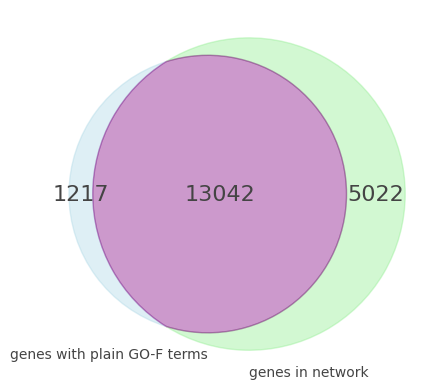

In [17]:
plot_venn_diagram(set([str(x) for x in d_sample_attributes.keys()]),set(G.nodes()),set1_name='genes with plain GO-F terms',set2_name='genes in network')

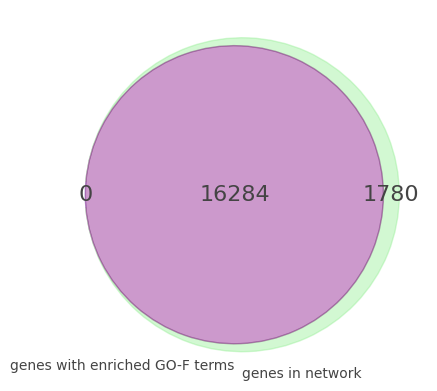

In [18]:
plot_venn_diagram(set(d_gene_terms_all.keys()),set(G.nodes()),set1_name='genes with enriched GO-F terms',set2_name='genes in network')

### Data preparation done

-----------------------------------------------------------------------------

### FEATURE MATRIX

In [19]:
# Create a feature matrix having genes as row indices sorted by d_gene_idx keys
# and features (annotations) as columns ordered like the set of annotation terms
t0 = time.time()


# dict to lookup annotation terms into column indices
d_t_idx = {}
c = 0
for t in sorted(s_terms):
    d_t_idx[t] = c
    c += 1
d_idx_go = {v:k for k,v in d_t_idx.items()}

# initialize feature matrix
# size (#rows,#cols)
size_featureMat = (len(d_gene_terms_all.keys()),len(s_terms))
FX = np.zeros(size_featureMat)

# iterating through rows (genes)
c = 0
for row in FX:
    gene = d_idx_gene_feat[c]
    for t in d_gene_terms_all[gene]:
        row[d_t_idx[t]]=1
    c += 1
        

n_samples, n_features = FX.shape
print('number of features (annotations) as columns: %s' %n_features)
print('number of samples (genes) as rows: %s' %n_samples)

print('CPU time %s' %(time.time()-t0))



number of features (annotations) as columns: 4444
number of samples (genes) as rows: 16284
CPU time 0.42583513259887695


### weighted GO terms

In order to amplify more specific GO term multiply each GO column by

$$ -\log \frac{n}{N} $$

where $N$ is the number of all GO terms and $n$ is the subvolumen derived from the tree.

Thus it is the probability to find either the term itself or any even more specific term when choosing a term randomly.

This procedure should also allow to get around the feature selection steps. 

### weight scaling for elements in the feature matrix  

In [20]:
N_tree = GO_F.number_of_nodes()
print(N_tree)

c_no= 0
for col in range(len(FX[0,:])):
    # print(col)
    # if col < 10:
    go = d_idx_go[col]
    try:
        vol = d_goF_subvol[go]
    except KeyError:
        vol = 1
        c_no += 1
    weight = vol + 1
    p = -np.log(weight/N_tree)
    FX[:,col] *= p

print(c_no)

11153
84


In [21]:

# n_samples, n_features = FX.shape
# print('number of features/annotations (columns): %s' %n_features)
# print('number of samples/genes (rows): %s' %n_samples)
# plt.figure(figsize=(10,6))
# im = plt.imshow(FX, cmap='viridis', vmax=np.max(FX))
# plt.colorbar(im, orientation='vertical')
# plt.savefig('FX_weighted.png',dpi=500)

### sanity of feature matrix

In [22]:
n_samples, n_features = FX.shape
print('number of features (columns): %s' %n_features)
print('number of samples (rows): %s' %n_samples)

# Count the zero entries
zero_count = np.count_nonzero(FX == 0)

print("Number of zero entries:", zero_count)

print("fraction of zero entries:", zero_count/n_samples/ n_features )


if np.isnan(FX).any():
    print("FX contains NaN values.")
else:
    print("FX does not contain NaN values.")
    

# Check for rows that sum up to zero
zero_sum_rows = np.where(FX.sum(axis=1) == 0)[0]

# Check for columns that sum up to zero
zero_sum_columns = np.where(FX.sum(axis=0) == 0)[0]

# Check if there are any zero-sum rows or columns
if zero_sum_rows.size > 0:
    print("There are rows that sum up to zero:", zero_sum_rows)
else:
    print("No rows sum up to zero.")

if zero_sum_columns.size > 0:
    print("There are columns that sum up to zero:", zero_sum_columns)
else:
    print("No columns sum up to zero.")



# Define a function to calculate matrix density
def matrix_density(matrix):
    num_nonzero = np.count_nonzero(matrix)
    total_elements = matrix.size
    density = num_nonzero / total_elements
    return density

density = matrix_density(FX)

print("Matrix density:", density)

number of features (columns): 4444
number of samples (rows): 16284
Number of zero entries: 72054020
fraction of zero entries: 0.9956875385401472
FX does not contain NaN values.
No rows sum up to zero.
No columns sum up to zero.
Matrix density: 0.004312461459852692


### UMAP coordinates based on Feature matrix

In [23]:
# metric = 'euclidean'
metric = 'cosine'
t0 = time.time()

# for mind in np.arange(.2,4.,.4):
n_neighs = 30
mind = 1.6
spread = 2.

reducer = umap.UMAP(n_components=2,
                    n_neighbors=n_neighs, 
                    metric = metric, 
                    min_dist=mind, 
                    spread = spread, 
                    init = 'spectral', 
                    low_memory=True)

umap_pos = reducer.fit_transform(FX)


d_umappos = {}
c = 0
for row in FX:
    gene = d_idx_gene_feat[c]
    xy = umap_pos[c,:].tolist()
    d_umappos[gene] = xy
    c += 1

print('UMAP time : %f ' %  (time.time()-t0))


UMAP time : 47.906818 


In [81]:
# with open('d_umappos_2D_GOF.pkl', 'wb') as f:
#     pk.dump(d_umappos, f)

### access UMAP network

In [24]:

# Access the underlying UMAP network
umap_network = reducer.graph_

# Convert UMAP network to NetworkX graph for visualization or analysis
umap_graph = nx.from_scipy_sparse_array(umap_network)

### draw UMAP  together with UMAP network 

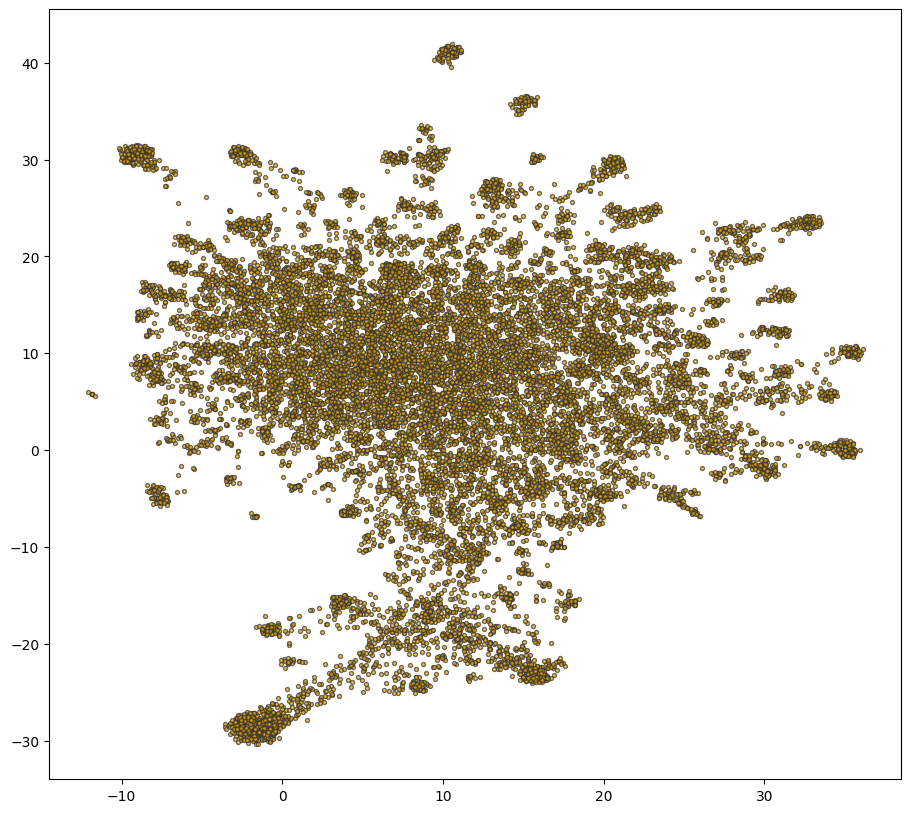

In [27]:
d_umappos_idx = {d_gene_idx_feat[k]:v for k, v in d_umappos.items()}

plt.figure(figsize=(11,10))
# nx.draw_networkx_edges(umap_graph,pos = d_umappos_idx, edge_color='#aaaaaa', alpha = .6)
plt.scatter(umap_pos[:,0],umap_pos[:,1], s = 8,c='#f8b100',edgecolors='#333333',alpha=.7)

# plt.savefig('UMAP_with_network.png',dpi=500)

the UMAP networks comes with weights

distribution of weights:

Text(0.5, 0, 'UMAP graph weights')

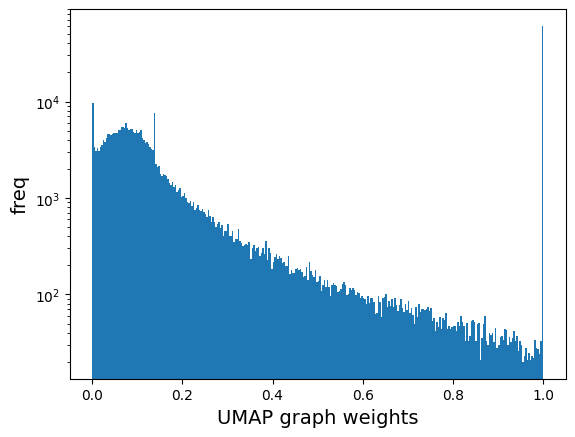

In [30]:
l_weights = []
# Check for edge weights
for u, v, d in umap_graph.edges(data=True):
    weight = d.get("weight")  # Check if weight attribute exists
    if weight is not None:
        l_weights.append(weight)
        # print(f"Edge ({u}, {v}) has weight {weight}")

h = plt.hist(l_weights,bins = 300)
plt.yscale('log')
plt.ylabel('freq',fontsize = 14)
plt.xlabel('UMAP graph weights',fontsize = 14)

### network pruning

In [58]:
weight_cutoff = 0.7

d_edge_weight = {}
G_umap_pruned = nx.Graph()

# Check for edge weights
for u, v, d in umap_graph.edges(data=True):
    weight = d.get("weight")  # Check if weight attribute exists
    if weight is not None and weight > weight_cutoff:
        G_umap_pruned.add_edge(u, v, weight=weight)
        d_edge_weight[(u,v)] = weight
print(Ginfo(G_umap_pruned))


Graph Name: 
Graph Type: Graph
Number of Nodes: 16771
Number of Edges: 102550
Connected: No
Number of Connected Components: 631
Directed: No


### components of UMAP network

In [59]:
# # Get a list of all connected components
# connected_components = list(nx.connected_components(G_umap_pruned))

# # Print the list of connected components
# for i, component in enumerate(connected_components):
#     print(f"size of component {i+1}: {len(component)}")

color all links  with low weights red

In [60]:
high_weights = []
low_weights = []

for edge in G_umap_pruned.edges():
    try:
        w = d_edge_weight[edge]
    except KeyError:
        w = d_edge_weight[(edge[1],edge[0])]

    if w > .5:
        high_weights.append(edge)
    else:
        low_weights.append(edge)


In [3]:
plt.figure(figsize=(11,10))
nx.draw_networkx_edges(G_umap_pruned,pos = d_umappos_idx, edgelist=high_weights, edge_color='#40b9d4', alpha = .6)
nx.draw_networkx_edges(G_umap_pruned,pos = d_umappos_idx, edgelist=low_weights, edge_color='#d2323c', alpha = .4)
plt.scatter(umap_pos[:,0],umap_pos[:,1], s = 8,c='#f8b100',edgecolors='#333333',alpha=.7)

plt.savefig('UMAP_with_network.png',dpi=500)

NameError: name 'plt' is not defined

In [4]:
# Get min and max values of the positions for axis limits
x_min, x_max = umap_pos[:, 0].min(), umap_pos[:, 0].max()
y_min, y_max = umap_pos[:, 1].min(), umap_pos[:, 1].max()

print(x_min, x_max)
print(y_min, y_max)

NameError: name 'umap_pos' is not defined

(10.0, 22.0)

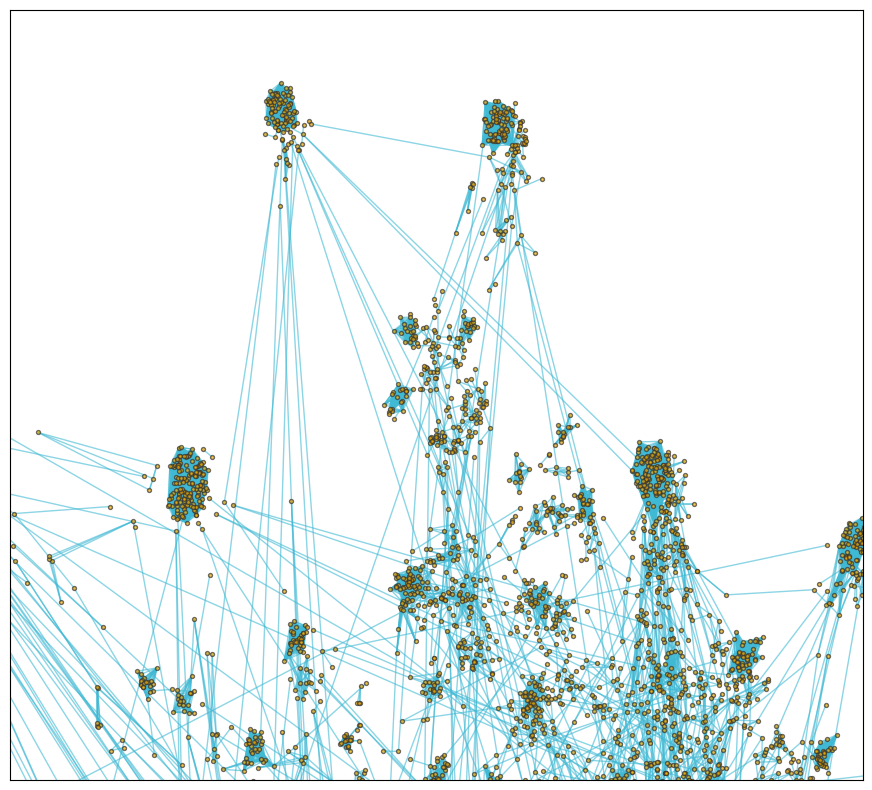

In [62]:
plt.figure(figsize=(11,10))
nx.draw_networkx_edges(G_umap_pruned,pos = d_umappos_idx, edgelist=high_weights, edge_color='#40b9d4', alpha = .6)
nx.draw_networkx_edges(G_umap_pruned,pos = d_umappos_idx, edgelist=low_weights, edge_color='#d2323c', alpha = .4)
plt.scatter(umap_pos[:,0],umap_pos[:,1], s = 8,c='#f8b100',edgecolors='#333333',alpha=.7)

plt.xlim([-5,15])
plt.ylim([10,22])

# plt.savefig('UMAP_with_network.png',dpi=500)

### GENE 2 GENE MATRIX & LINKAGE

generates levels of clustering

takes ca 10 mins

In [25]:

t0 = time.time()

D = dist.pdist(FX,metric = metric)

L = sch.linkage(D, method = 'average',metric = metric)
L[L<0.0] = 0.0


print('time.time(): %f' % (time.time()-t0))

time.time(): 873.494302


In [32]:
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import squareform
condensed_D = squareform(D) 

# Choosing the number of clusters based on silhouette score
silhouette_scores = []
range_n_clusters = list(range(200, 800,20))  # Example range from 2 to 9 clusters
for n_clusters in range_n_clusters:
    labels = fcluster(L, n_clusters, criterion='maxclust')
    score = silhouette_score(condensed_D, labels, metric='precomputed')
    silhouette_scores.append(score)

optimal_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print("The optimal number of clusters:", optimal_clusters)

The optimal number of clusters: 780


### max sized vs trivial cluster eval

300


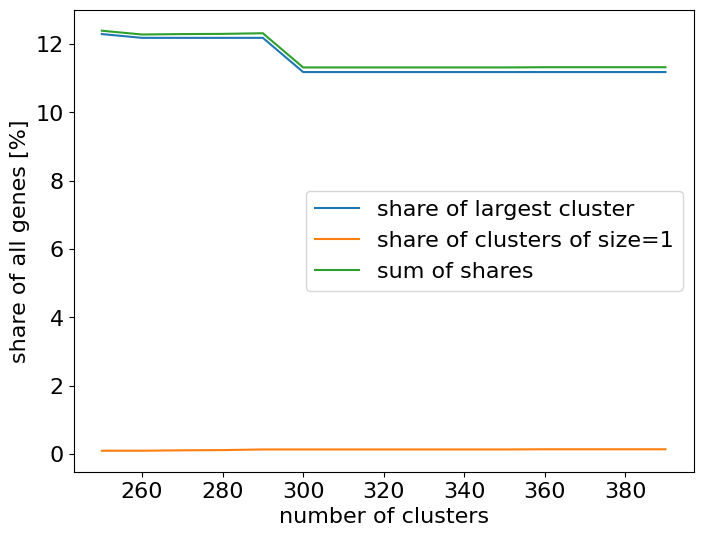

In [35]:
cs_range = range(250,400,10)
l_frac_bigvs1 = []
l_frac_big = []
l_frac_s1 = []
for max_num_clusters in cs_range:
    l_cluster = fcluster(L, max_num_clusters, criterion='maxclust')
    # size of clusters
    d_c_s = {}
    for cl in set(l_cluster):
        d_c_s[cl] =  list(l_cluster).count(cl)

    for a,b in sorted(d_c_s.items(), key = lambda x: x[1], reverse = True)[:1]:
        max_size = b
        max_size_frac = 100.*b/n_samples
#         print('size of largest cluster: %s (cov = %.0f%%)' %(max_size,max_size_frac))

    c_1_number = list(d_c_s.values()).count(1)
    c_1_number_frac = 100.*c_1_number/n_samples
    l_frac_big.append(max_size_frac)
    l_frac_s1.append(c_1_number_frac)
    l_frac_bigvs1.append(max_size_frac+c_1_number_frac)

index_min = np.argmin(np.array(l_frac_bigvs1))
#     print(index_min)
min_cs = cs_range[index_min]

print(min_cs)        


plt.figure(figsize=(8,6))


# plt.bar(range(len(d_c_s.keys()))[:40],sorted(d_c_s.values(),reverse = True)[:40])    
plt.plot(cs_range,l_frac_big,label='share of largest cluster')
plt.plot(cs_range,l_frac_s1, label = 'share of clusters of size=1')
plt.plot(cs_range,l_frac_bigvs1,label='sum of shares')

plt.legend(fontsize =16)
plt.xlabel('number of clusters',fontsize =16)
plt.ylabel('share of all genes [%]',fontsize =16)

ax = plt.gca()
tick_color = 'k'#'#ffffff'
plt.tick_params(axis='both', which='major', colors=tick_color,labelsize=16)
ax.xaxis.label.set_color(tick_color)
ax.yaxis.label.set_color(tick_color)



In [28]:
# from silouhette
# num_clusters = optimal_clusters

# from 2nd method
num_clusters = 300

l_cluster = fcluster(L, num_clusters, criterion='maxclust')

d_clID_size = Counter((l_cluster.tolist()))
print('clusterID , #genes in cluster')
c = 0 
sum = 0
for k, v in d_clID_size.items():
    c += 1
    sum += v
    # print(k,v)
print('there are %s clusters that contain %s genes in total' %(c,sum))

# dict for size distribution of clusters
d_size_freq = dict(Counter(d_clID_size.values()))


clusterID , #genes in cluster
there are 300 clusters that contain 16284 genes in total


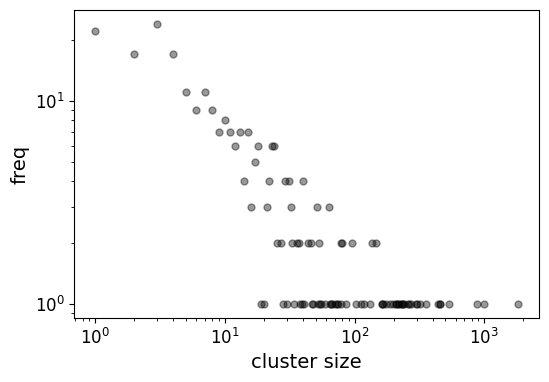

In [29]:
fig_fontsize = 14

plt.figure(figsize=(6,4))
# plt.bar(range(len(d_c_s.keys()))[:40],sorted(d_c_s.values(),reverse = True)[:40])    
plt.scatter(d_size_freq.keys(),d_size_freq.values(),c = 'k',s = 25,alpha = .4)
plt.xscale('log')
plt.yscale('log')

plt.xlabel('cluster size',fontsize =fig_fontsize)
plt.ylabel('freq',fontsize =fig_fontsize)

ax = plt.gca()
tick_color = 'k'
plt.tick_params(axis='both', which='major', colors=tick_color,labelsize=fig_fontsize-2)
ax.xaxis.label.set_color(tick_color)
ax.yaxis.label.set_color(tick_color)


In [30]:
def generate_colors(n):
    # Generate equally spaced Hue values
    hues = [i/n for i in range(n)]
    
    # Set Saturation and Lightness to fixed values
    saturation = 0.5
    lightness = 0.5
    
    # Convert HSL colors to RGB colors and then to hex colors
    rgb_colors = [colorsys.hls_to_rgb(hue, lightness, saturation) for hue in hues]
    hex_colors = [f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}" for r, g, b in rgb_colors]
    
    return hex_colors

# minimal size of a cluster to get a color
min_size = 70

l_small_clusterIDS = [c for c, s in d_clID_size.items() if s < min_size]
print('Only clusters bigger than %s genes get colors.' %min_size)
print('The rest will be gray.')

print('Thus we need %s different colors.' %(len(set(l_cluster))-len(l_small_clusterIDS)))

# generate as many colors as we have bigger clusters
l_col = generate_colors(len(set(l_cluster))-len(l_small_clusterIDS))
rd.shuffle(l_col)
# l_col = cemm_pal(len(set(l_cluster)))
d_cl_col = {}
c = 0
for cl,size in sorted(d_clID_size.items(), key = lambda x: x[1], reverse = True):
    if size < min_size:
        d_cl_col[cl] = '#888888'
    else:
        d_cl_col[cl] = l_col[c]
    c +=1

# assign colors to each node
d_node_col = {}
d_sym_col = {}

for n, cl in enumerate(l_cluster):
    col = d_cl_col[cl]
    gene = d_idx_gene_feat[n]
    sym = entrez_to_symbols.get(gene, gene)
    d_node_col[gene] = col
    d_sym_col[sym] = col


non_dis_genes = set(G.nodes) - set(d_node_col.keys())
# include the non-annotated nodes as well
non_dis_col = '#444444'
for gene in non_dis_genes:
    sym = entrez_to_symbols.get(gene, gene)
    d_node_col[gene] = non_dis_col
    d_sym_col[sym] = non_dis_col




Only clusters bigger than 70 genes get colors.
The rest will be gray.
Thus we need 47 different colors.


In [31]:
# make dict with clusterID as keys and set of genes as values
d_cl_setgenes = defaultdict(list)

for n, cl in enumerate(l_cluster):
    gene = d_idx_gene_feat[n]
    d_cl_setgenes[cl].append(gene)

# and vice versa
d_gene_clID = {}
for clID, set_genes in d_cl_setgenes.items():
    for gene in set_genes:
        d_gene_clID[gene] = clID



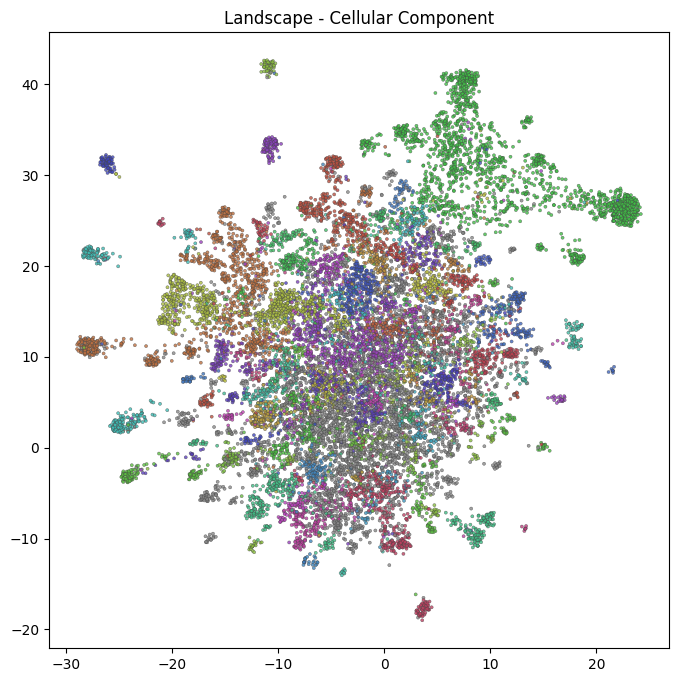

In [32]:
# shuffle colors

rd.shuffle(l_col)
# l_col = cemm_pal(len(set(l_cluster)))
d_cl_col = {}
c = 0
for cl,size in sorted(d_clID_size.items(), key = lambda x: x[1], reverse = True):
    if size < min_size:
        d_cl_col[cl] = '#888888'
    else:
        d_cl_col[cl] = l_col[c]
    c +=1

# assign colors to each node
d_node_col = {}
d_sym_col = {}

for n, cl in enumerate(l_cluster):
    col = d_cl_col[cl]
    gene = d_idx_gene_feat[n]
    sym = entrez_to_symbols.get(gene, gene)
    d_node_col[gene] = col
    d_sym_col[sym] = col


non_dis_genes = set(G.nodes) - set(d_node_col.keys())
# include the non-annotated nodes as well
non_dis_col = '#444444'
for gene in non_dis_genes:
    sym = entrez_to_symbols.get(gene, gene)
    d_node_col[gene] = non_dis_col
    d_sym_col[sym] = non_dis_col

##########################################


# Extract x, y, and z values from the dictionary
x_values = [coord[0] for coord in d_umappos.values()]
y_values = [coord[1] for coord in d_umappos.values()]
# z_values = [coord[2] for coord in d_umappos.values()]

# Create a list of colors based on your dictionary
colors = [d_node_col[key] for key in d_umappos.keys()]
# '#40b9d4'#
plt.figure(figsize=(8, 8))

plt.scatter(x_values, y_values, c=colors, marker='o', s= 5,edgecolors='#444444',linewidths=.3, alpha=.8)
plt.title('Landscape - Cellular Component')
plt.savefig('func_land.png', dpi=500)


### Cluster characterization

Gene set enrichment analysis for all sets

providing the most characteristic terms per cluster

In [33]:
sig_level = .01

# big clusters:

set_bigclusters = set(l_cluster)-set(l_small_clusterIDS)

# select disease genes as background only 
background = len(d_sample_attributes.keys())

d_cl_charac_terms = {}
for cID in set_bigclusters:
    sampleset = [int(x) for x in d_cl_setgenes[cID]]

    d_dis_p = fisher_test(sig_level,sampleset,d_sample_attributes,d_attributes_sample,background)
    l_terms_pvals = []
    for x,p in d_dis_p.items():
        if p < sig_level:
            l_terms_pvals.append([x,p])
    d_cl_charac_terms[cID] = l_terms_pvals



In [34]:
for cID, set_terms in d_cl_charac_terms.items():
    print('cluster no: ', cID)
    print('terms:')
    for term,p_val in set_terms:
        try:
            minlog_p_val = - np.log(p_val)
            print(term,d_go_names[term],d_goF_subvol[term],minlog_p_val)
        except:
            pass
    print('\n')

cluster no:  256
terms:
GO:1901363 heterocyclic compound binding 443 619.0095969634103
GO:0035925 mRNA 3'-UTR AU-rich region binding 1 26.202656228733655
GO:0003676 nucleic acid binding 313 inf
GO:0008143 poly(A) binding 1 32.559136025335896
GO:0017069 snRNA binding 17 43.5704711833271
GO:0005488 binding 1851 161.91126279749977
GO:0043022 ribosome binding 2 8.165777199078287
GO:0043021 ribonucleoprotein complex binding 15 20.00216402684652
GO:0097159 organic cyclic compound binding 485 610.7194570532956
GO:0003747 translation release factor activity 3 5.6360348885135645
GO:0009982 pseudouridine synthase activity 4 7.2574459362101
GO:0003743 translation initiation factor activity 1 72.85347638745088
GO:1990948 ubiquitin ligase inhibitor activity 1 8.251431526579381
GO:0003724 RNA helicase activity 3 70.14856779152582
GO:0019843 rRNA binding 11 41.978334892019255
GO:0008186 ATP-dependent activity, acting on RNA 3 67.54343653323711
GO:0003729 mRNA binding 75 267.5033337392264
GO:0030515 s

/var/folders/vs/yk3q3pjs71x993d_n_y72f2dg7t8fw/T/ipykernel_946/3321959923.py:6: RuntimeWarning:

divide by zero encountered in log



In [35]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [36]:
all_terms = []

for cID in set_bigclusters:
    terms2label = []

    set_terms =  d_cl_charac_terms[cID]

    for term,p_val in set_terms:
        try:
            terms2label.append(d_go_names[term])
        except:
            pass

    # Sample data: replace this with your actual list of terms.
    terms = terms2label

    # Concatenate all the terms into a single string.
    text = ' '.join(terms)
    # Tokenize the text.
    tokens = word_tokenize(text)
    # Convert to lower case.
    tokens = [word.lower() for word in tokens]
    # Remove punctuation and non-alphabetic tokens.
    words = [word for word in tokens if word.isalpha()]
    # Filter out stop words.
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]
    all_terms.append(words)
# flatten
# all_terms = [x for xs in all_terms for x in xs]


d_cID_labels = {}


for cID in set_bigclusters:

    terms2label = []

    set_terms =  d_cl_charac_terms[cID]

    for term,p_val in set_terms:
        try:
            terms2label.append(d_go_names[term])
        except:
            pass
    # Sample data: replace this with your actual list of terms.
    terms = terms2label

    # Concatenate all the terms into a single string.
    text = ' '.join(terms)
    # Tokenize the text.
    tokens = word_tokenize(text)
    # Convert to lower case.
    tokens = [word.lower() for word in tokens]
    # Remove punctuation and non-alphabetic tokens.
    words = [word for word in tokens if word.isalpha()]
    # Filter out stop words.
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]

    # Count and display the frequency of each word.
    word_counts = Counter(words)
    most_common = word_counts.most_common(2)

    label = ''
    for x,f in most_common:
        label += x+' '

    label = label[:-1]
    d_cID_labels[cID] = label

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

# number of terms for label
n = 2

# Create a list of strings, each representing the terms in one cluster.
cluster_documents = [' '.join(cluster) for cluster in all_terms]
    
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the documents
tfidf_matrix = vectorizer.fit_transform(cluster_documents)

# Get feature names to access the terms.
feature_names = vectorizer.get_feature_names_out()

# For each cluster's document, find the highest TF-IDF scores
for i, cID in enumerate(set_bigclusters):
    # Get the tf-idf row for this cluster
    row = np.squeeze(tfidf_matrix[i].toarray())

    # Sort the tf-idf values in descending order
    sorted_indices = np.argsort(row)[::-1]

    # Generate the label with the two terms with the highest TF-IDF score
    top_terms = [feature_names[idx] for idx in sorted_indices[:n]]
    label = ' '.join(top_terms)
    d_cID_labels[cID] = label


In [63]:
d_cID_labels

{256: 'translation binding',
 259: 'dna telomeric',
 261: 'transcription coactivator',
 134: 'activity acetyltransferase',
 262: 'transcription dna',
 137: 'structural constituent',
 140: 'kinase tyrosine',
 269: 'methyltransferase trna',
 271: 'exonuclease activity',
 147: 'receptor kinase',
 275: 'binding phosphatidylinositol',
 153: 'channel inhibitor',
 155: 'phosphatase activity',
 283: 'activity ion',
 158: 'endopeptidase activity',
 160: 'gtpase regulator',
 162: 'kinase protein',
 163: 'protein conjugating',
 290: 'binding activity',
 165: 'adaptor necrosis',
 291: 'binding acid',
 295: 'transporter transmembrane',
 296: 'dna activity',
 170: 'endopeptidase activity',
 171: 'activity endopeptidase',
 174: 'adaptor activity',
 53: 'activity glycogen',
 184: 'kinase protein',
 57: 'transporter activity',
 187: 'microtubule activity',
 188: 'binding actin',
 190: 'adhesion binding',
 195: 'binding rna',
 68: 'transporter transmembrane',
 76: 'channel activity',
 77: 'channel trans

### check for uniqueness

In [39]:
# Convert each pair into a sorted tuple and add to a set
unique_pairs = set()
duplicates = set()
for pair in list(d_cID_labels.values()):
    sorted_pair = tuple(sorted(pair.split()))
    if sorted_pair in unique_pairs:
        duplicates.add(sorted_pair)
    unique_pairs.add(sorted_pair)

# Print the results
print("Unique pairs:")
for pair in unique_pairs:
    print(' '.join(pair))

if duplicates:
    print("\nDuplicates found:")
    for pair in duplicates:
        print(' '.join(pair))
else:
    print("\nNo duplicates found")

Unique pairs:
activity transporter
methyltransferase trna
conjugating protein
activity adaptor
activity glycogen
dna transcription
channel inhibitor
activity channel
binding translation
coactivator transcription
dna telomeric
constituent structural
kinase protein
kinase receptor
binding chromatin
chemokine receptor
transmembrane transporter
activity phosphatase
activity phospholipase
nuclear transcription
actin binding
activity binding
kinase tyrosine
histone methyltransferase
adhesion binding
acid binding
nuclear signal
activity microtubule
activity ion
binding rna
acetyltransferase activity
chaperone fucosidase
activity receptor
activity exonuclease
binding phosphatidylinositol
activity dna
channel transporter
activity endopeptidase
binding receptor
gtpase regulator
adaptor necrosis

Duplicates found:
activity receptor
kinase protein
activity endopeptidase
transmembrane transporter
activity phosphatase


### identify cluster IDs on map

In [64]:
l_col = generate_colors(len(set(l_cluster))-len(l_small_clusterIDS))
rd.shuffle(l_col)


for i,cID in enumerate(set_bigclusters):    
    # rd.shuffle(l_col)
    d_cl_col = {}
    for cl,size in sorted(d_clID_size.items(), key = lambda x: x[1], reverse = True):
        if size < min_size:
            d_cl_col[cl] = '#888888'
        elif cl == cID:
            d_cl_col[cl] = l_col[i]
        else:
            d_cl_col[cl] = '#888888'


    # assign colors to each node
    d_node_col = {}
    d_sym_col = {}

    for n, cl in enumerate(l_cluster):
        col = d_cl_col[cl]
        gene = d_idx_gene_feat[n]
        sym = entrez_to_symbols.get(gene, gene)
        d_node_col[gene] = col
        d_sym_col[sym] = col


    non_dis_genes = set(G.nodes) - set(d_node_col.keys())
    # include the non-annotated nodes as well
    non_dis_col = '#444444'
    for gene in non_dis_genes:
        sym = entrez_to_symbols.get(gene, gene)
        d_node_col[gene] = non_dis_col
        d_sym_col[sym] = non_dis_col


    # Create a list of colors based on your dictionary
    colors = [d_node_col[key] for key in d_umappos.keys()]
    # '#40b9d4'#
    plt.figure(figsize=(8, 8))

    plt.scatter(x_values, y_values, c=colors, marker='o', s= 5)
    plt.title('cluster: %s' %cID)

    plt.savefig('landscape_%s.png' %cID)

    plt.clf()

/var/folders/vs/yk3q3pjs71x993d_n_y72f2dg7t8fw/T/ipykernel_946/2676576569.py:41: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

### cluster distances from distance matrix

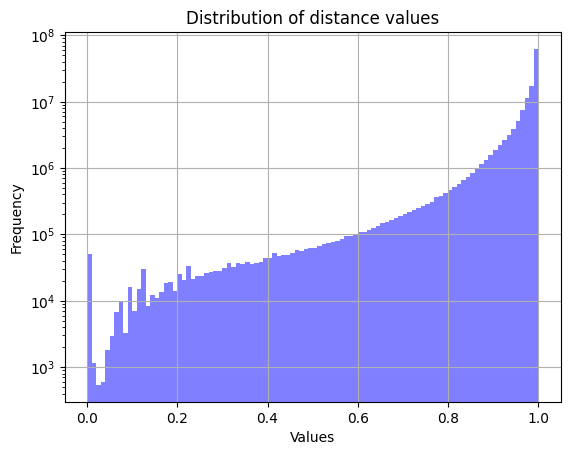

In [67]:
flattened_matrix = D.flatten()  

# Create a histogram
plt.hist(flattened_matrix, bins=100, color='blue', alpha=0.5)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of distance values')
plt.grid(True)
plt.yscale('log')

# Show or save the histogram
plt.show()

In [60]:
from scipy.spatial.distance import squareform
condensed_D = squareform(D)

mean_D = np.mean(D)
std_D = np.std(D)

compare distances from the feature metrics directly with the 2d and 3d UMAP latent space. 
MEaybe there is a better correspondance in 3D!!

In [65]:
# take two distant clusters

cl_ID1 = 76 # channel activity
cl_ID2 = 158 # endopetidase inhibitor

c = 0
avg_dist = 0
for gene1 in d_cl_setgenes[cl_ID1]:
    idx_1 = d_gene_idx_feat[gene1]
    for gene2 in d_cl_setgenes[cl_ID2]:
        idx_2 = d_gene_idx_feat[gene2]
        dist = condensed_D[idx_1,idx_2]
        c += 1
        avg_dist += dist

print(avg_dist/c)

0.9842774241553044


In [70]:
# take two close clusters

cl_ID1 = 76 # channel activity
cl_ID2 = 88 # chemokine receptor activity

c = 0
avg_dist = 0
for gene1 in d_cl_setgenes[cl_ID1]:
    idx_1 = d_gene_idx_feat[gene1]
    for gene2 in d_cl_setgenes[cl_ID2]:
        idx_2 = d_gene_idx_feat[gene2]
        dist = condensed_D[idx_1,idx_2]
        c += 1
        avg_dist += dist

print(avg_dist/c)

0.9510227167810417


choose two random clusters

In [75]:
cl_ID1, cl_ID2 = rd.sample(list(set_bigclusters),2)

c = 0
avg_dist = 0
for gene1 in d_cl_setgenes[cl_ID1]:
    idx_1 = d_gene_idx_feat[gene1]
    for gene2 in d_cl_setgenes[cl_ID2]:
        idx_2 = d_gene_idx_feat[gene2]
        dist = condensed_D[idx_1,idx_2]
        c += 1
        avg_dist += dist

print('clusters %s (%s) and %s (%s) have a distance of %s' 
      %(cl_ID1, cl_ID2, d_cID_labels[cl_ID1], d_cID_labels[cl_ID2], avg_dist/c))

clusters 259 (160) and dna telomeric (gtpase regulator) have a distance of 0.9734744153611427


In [77]:
# cl_ID1, cl_ID2 = rd.sample(list(set_bigclusters),2)
n = 0
for cl_ID1, cl_ID2 in it.combinations(list(set_bigclusters),2):
    c = 0
    avg_dist = 0
    for gene1 in d_cl_setgenes[cl_ID1]:
        idx_1 = d_gene_idx_feat[gene1]
        for gene2 in d_cl_setgenes[cl_ID2]:
            idx_2 = d_gene_idx_feat[gene2]
            dist = condensed_D[idx_1,idx_2]
            c += 1
            avg_dist += dist

    print('clusters %s (%s) and %s (%s) have a distance of %s' 
        %(cl_ID1, d_cID_labels[cl_ID1], cl_ID2, d_cID_labels[cl_ID2], avg_dist/c))
    n += 1

    if n>30:
        break

clusters 256 (translation binding) and 259 (dna telomeric) have a distance of 0.8778811044057102
clusters 256 (translation binding) and 261 (transcription coactivator) have a distance of 0.9378063253415846
clusters 256 (translation binding) and 134 (activity acetyltransferase) have a distance of 0.9639214775232466
clusters 256 (translation binding) and 262 (transcription dna) have a distance of 0.8894620638355601
clusters 256 (translation binding) and 137 (structural constituent) have a distance of 0.9497720763470571
clusters 256 (translation binding) and 140 (kinase tyrosine) have a distance of 0.972504344353179
clusters 256 (translation binding) and 269 (methyltransferase trna) have a distance of 0.9095662314414198
clusters 256 (translation binding) and 271 (exonuclease activity) have a distance of 0.885802700166676
clusters 256 (translation binding) and 147 (receptor kinase) have a distance of 0.9697790034569314
clusters 256 (translation binding) and 275 (binding phosphatidylinosito

take one cluster and look around

In [78]:
cl_ID1 = 57
d_speccluster2all = {}
for cl_ID2 in set_bigclusters:
    c = 0
    avg_dist = 0
    for gene1 in d_cl_setgenes[cl_ID1]:
        idx_1 = d_gene_idx_feat[gene1]
        for gene2 in d_cl_setgenes[cl_ID2]:
            idx_2 = d_gene_idx_feat[gene2]
            dist = condensed_D[idx_1,idx_2]
            c += 1
            avg_dist += dist
    d_speccluster2all[d_cID_labels[cl_ID2]] = dist
    # print('clusters %s (%s) and %s (%s) have a distance of %s' 
    #     %(cl_ID1, cl_ID2, d_cID_labels[cl_ID1], d_cID_labels[cl_ID2], avg_dist/c))

In [80]:
for a, b in sorted(d_speccluster2all.items(), key=lambda x: x[1]):
    print(a, b)
                   

transporter activity 0.0
channel transporter 0.7646498776336565
receptor activity 0.8158507306907675
transporter transmembrane 0.8360693189019779
channel activity 0.8596251153435664
exonuclease activity 0.9396840830355753
gtpase regulator 0.9496516253645411
binding phosphatidylinositol 0.960356255339397
dna activity 0.999581348639961
phosphatase activity 0.999703556461795
activity endopeptidase 0.9997344255988324
activity glycogen 0.9997347671742497
activity phospholipase 0.9997347756582742
receptor kinase 0.9997950735429297
methyltransferase trna 0.9998087649625698
adaptor necrosis 0.9998092756269654
activity ion 0.9998385182393105
binding acid 0.9998420266268286
methyltransferase histone 0.9998477717866107
activity acetyltransferase 0.9998565388525481
nuclear transcription 0.999858831923251
protein conjugating 0.9998635820970835
kinase protein 0.9998685060681369
binding activity 0.9998875842251984
endopeptidase activity 0.9998924077619162
binding receptor 0.9999999999377317
chaperone

euclidean dists on latent space

In [84]:
cl_ID1 = 57
d_speccluster2all_latent = {}
for cl_ID2 in set_bigclusters:
    c = 0
    avg_dist = 0
    for gene1 in d_cl_setgenes[cl_ID1]:
        x1,y1 = d_umappos[gene1]

        for gene2 in d_cl_setgenes[cl_ID2]:
            x2,y2 = d_umappos[gene2]

            dist = np.sqrt((x1-x2)**2 + (y1-y2)**2) 
            c += 1
            avg_dist += dist
    d_speccluster2all_latent[d_cID_labels[cl_ID2]] = dist
    # print('clusters %s (%s) and %s (%s) have a distance of %s' 
    #     %(cl_ID1, cl_ID2, d_cID_labels[cl_ID1], d_cID_labels[cl_ID2], avg_dist/c))



In [85]:

for a, b in sorted(d_speccluster2all.items(), key=lambda x: x[1]):
    print(a, b,d_speccluster2all_latent[a])

transporter activity 0.0 0.0
channel transporter 0.7646498776336565 41.918725941955245
receptor activity 0.8158507306907675 33.48767305676878
transporter transmembrane 0.8360693189019779 42.859335027680046
channel activity 0.8596251153435664 39.75179740059372
exonuclease activity 0.9396840830355753 24.26256823934084
gtpase regulator 0.9496516253645411 31.113592058964638
binding phosphatidylinositol 0.960356255339397 38.96920315710026
dna activity 0.999581348639961 32.49784694922376
phosphatase activity 0.999703556461795 37.06869646598825
activity endopeptidase 0.9997344255988324 34.3715420967556
activity glycogen 0.9997347671742497 44.60277551237123
activity phospholipase 0.9997347756582742 41.001563326660246
receptor kinase 0.9997950735429297 33.25666617615205
methyltransferase trna 0.9998087649625698 27.002480528617266
adaptor necrosis 0.9998092756269654 34.630376468224526
activity ion 0.9998385182393105 27.412902168578384
binding acid 0.9998420266268286 32.29932858109436
methyltrans

In [99]:
[-np.log(abs(x-1)) for x in d_speccluster2all.values()]

[24.82093986067459,
 24.848910442047092,
 24.767121368888713,
 8.849446308887995,
 25.082809664428268,
 25.018455702222518,
 25.587617823771616,
 8.562007323977086,
 2.808159247155298,
 8.492859389189315,
 3.227822107266533,
 25.23405676231401,
 8.123653785299208,
 8.731118358586349,
 9.137162049606559,
 2.988788941660189,
 8.936549852939184,
 8.899787568114183,
 9.093306285142289,
 8.564681245267844,
 8.753084063371007,
 1.8083116167422886,
 7.778472060688879,
 8.233615526153079,
 24.766671801194295,
 8.23490252997334,
 -0.0,
 24.9071756386847,
 24.61552901833951,
 24.46939766899532,
 24.299227389892337,
 1.9634386876055518,
 1.4466809912016456,
 1.6920086040097007,
 24.855973417153674,
 8.234934517568206,
 23.499568621769217,
 25.266166928897718,
 24.158695512127164,
 8.865559343813155,
 8.790129759220681,
 25.373733343587666]

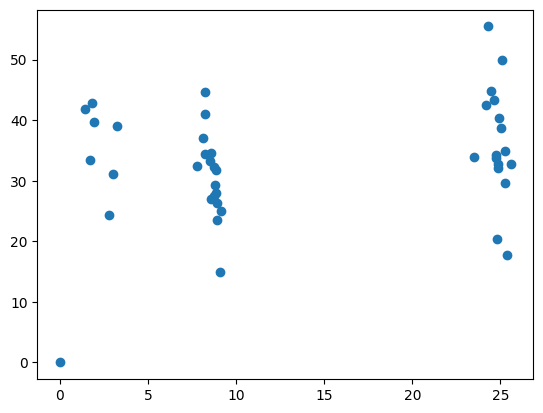

In [100]:

plt.scatter([-np.log(abs(x-1)) for x in d_speccluster2all.values()],d_speccluster2all_latent.values())
# plt.xlim([.0,.2])
# plt.xscale('log')

color only some of the clusters to consider them more closely

In [ ]:
 295: 'transporter transmembrane',
 296: 'dna activity',
 170: 'endopeptidase activity',
 171: 'activity endopeptidase',
 174: 'adaptor activity',
 53: 'activity glycogen',
 184: 'kinase protein',
 57: 'transporter activity',
 187: 'microtubule activity',
 188: 'binding actin',
 190: 'adhesion binding',
 195: 'binding rna',
 68: 'transporter transmembrane',

1061


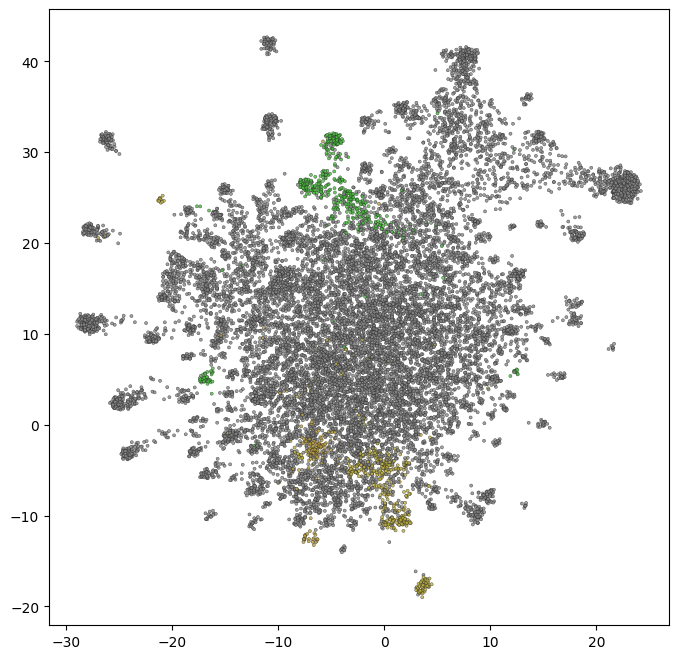

In [153]:
l_col = generate_colors(len(set(l_cluster))-len(l_small_clusterIDS))
rd.shuffle(l_col)

# clusters to be colored
cl_ID1 = 163 # protein conjugating
cl_ID2 = 88 # chemokine receptor activity
cl_ID3 = 295 # transporter transmembrane
l_clusters2colr = [cl_ID1,cl_ID2,cl_ID3]

d_cl_col = {}

for i,cl in enumerate(set_bigclusters):    
    if cl in l_clusters2colr:
        d_cl_col[cl] = l_col[i]
    else:
        d_cl_col[cl] = '#888888'




# assign colors to each node
d_node_col_2 = {}

c = 0
for n, cl in enumerate(l_cluster):
    if cl in l_clusters2colr:
        c += 1
        col = d_cl_col[cl]
        # print(col)
        gene = d_idx_gene_feat[n]
        d_node_col_2[gene] = col
        # sym = entrez_to_symbols.get(gene, gene)
        # d_sym_col[sym] = col
    else:
        col = '#888888'
        gene = d_idx_gene_feat[n]
        d_node_col_2[gene] = col

# gray_genes = set(G.nodes) - set(d_cl_col.keys())
# # include the non-annotated nodes as well
# non_dis_col = '#444444'
# for gene in gray_genes:
#     sym = entrez_to_symbols.get(gene, gene)
#     d_node_col_2[gene] = non_dis_col
    # d_sym_col[sym] = non_dis_col

##########################################

print(c)

# Extract x, y, and z values from the dictionary
x_values = [coord[0] for coord in d_umappos.values()]
y_values = [coord[1] for coord in d_umappos.values()]
# z_values = [coord[2] for coord in d_umappos.values()]

# Create a list of colors based on your dictionary
colors = [d_node_col_2[key] for key in d_umappos.keys()]
# '#40b9d4'#
plt.figure(figsize=(8, 8))

plt.scatter(x_values, y_values, c=colors, marker='o', s= 5,edgecolors='#222222',linewidths=.3, alpha=.8)
# plt.title('Landscape - Cellular Component')
# plt.savefig('func_land.png', dpi=500)


In [156]:

# cl_ID1, cl_ID2 = rd.sample(list(set_bigclusters),2)
n = 0
for cl_ID1, cl_ID2 in it.combinations(list(l_clusters2colr),2):
    c = 0
    avg_dist = 0
    avg_dist_scaled = 0
    for gene1 in d_cl_setgenes[cl_ID1]:
        idx_1 = d_gene_idx_feat[gene1]
        for gene2 in d_cl_setgenes[cl_ID2]:
            idx_2 = d_gene_idx_feat[gene2]
            dist = condensed_D[idx_1,idx_2]
            dist_scaled = 10*(dist - mean_D) / std_D
            c += 1
            avg_dist += dist
            avg_dist_scaled += dist_scaled

    print('clusters %s (%s) and %s (%s) have a distance of %s (%s)' 
        %(cl_ID1, d_cID_labels[cl_ID1], 
          cl_ID2, d_cID_labels[cl_ID2], 
          round(avg_dist/c,5),avg_dist_scaled/c))
    n += 1


clusters 163 (protein conjugating) and 88 (receptor activity) have a distance of 0.98833 (3.4481192722836562)
clusters 163 (protein conjugating) and 295 (transporter transmembrane) have a distance of 0.98225 (2.8036617756937208)
clusters 88 (receptor activity) and 295 (transporter transmembrane) have a distance of 0.95292 (-0.3038730115176057)


In [157]:
mean_D

0.9557859210936822

642


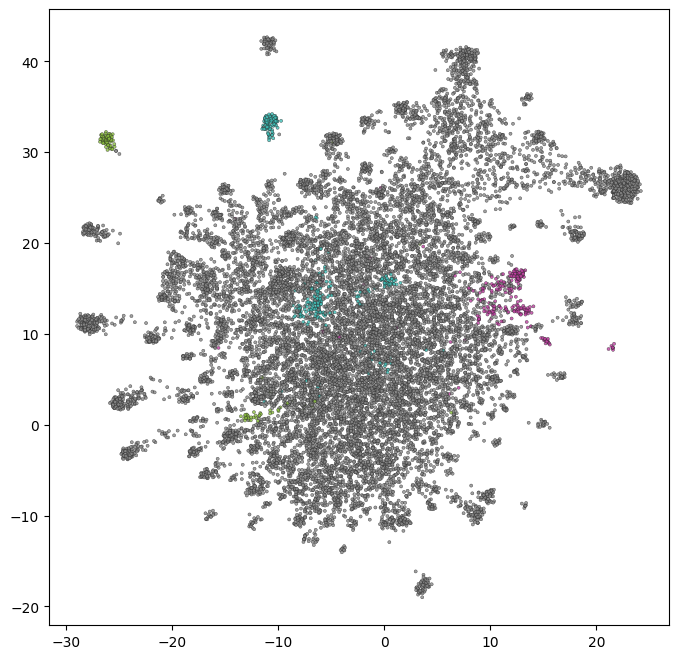

In [144]:
l_col = generate_colors(len(set(l_cluster))-len(l_small_clusterIDS))
rd.shuffle(l_col)

# clusters to be colored
cl_ID1 = 187 # microtubule activity
cl_ID2 = 57 # transporter activity
cl_ID3 = 158 # endopeptidase inhibitor
l_clusters2colr = [cl_ID1,cl_ID2,cl_ID3]

d_cl_col = {}

for i,cl in enumerate(set_bigclusters):    
    if cl in l_clusters2colr:
        d_cl_col[cl] = l_col[i]
    else:
        d_cl_col[cl] = '#888888'




# assign colors to each node
d_node_col_2 = {}

c = 0
for n, cl in enumerate(l_cluster):
    if cl in l_clusters2colr:
        c += 1
        col = d_cl_col[cl]
        # print(col)
        gene = d_idx_gene_feat[n]
        d_node_col_2[gene] = col
        # sym = entrez_to_symbols.get(gene, gene)
        # d_sym_col[sym] = col
    else:
        col = '#888888'
        gene = d_idx_gene_feat[n]
        d_node_col_2[gene] = col

# gray_genes = set(G.nodes) - set(d_cl_col.keys())
# # include the non-annotated nodes as well
# non_dis_col = '#444444'
# for gene in gray_genes:
#     sym = entrez_to_symbols.get(gene, gene)
#     d_node_col_2[gene] = non_dis_col
    # d_sym_col[sym] = non_dis_col

##########################################

print(c)

# Extract x, y, and z values from the dictionary
x_values = [coord[0] for coord in d_umappos.values()]
y_values = [coord[1] for coord in d_umappos.values()]
# z_values = [coord[2] for coord in d_umappos.values()]

# Create a list of colors based on your dictionary
colors = [d_node_col_2[key] for key in d_umappos.keys()]
# '#40b9d4'#
plt.figure(figsize=(8, 8))

plt.scatter(x_values, y_values, c=colors, marker='o', s= 5,edgecolors='#222222',linewidths=.3, alpha=.8)
# plt.title('Landscape - Cellular Component')
# plt.savefig('func_land.png', dpi=500)


In [151]:

# cl_ID1, cl_ID2 = rd.sample(list(set_bigclusters),2)
n = 0
for cl_ID1, cl_ID2 in it.combinations(list(l_clusters2colr),2):
    c = 0
    avg_dist = 0
    for gene1 in d_cl_setgenes[cl_ID1]:
        idx_1 = d_gene_idx_feat[gene1]
        for gene2 in d_cl_setgenes[cl_ID2]:
            idx_2 = d_gene_idx_feat[gene2]
            dist = condensed_D[idx_1,idx_2]
            dist_scaled = 1e5*(dist - mean_D) / std_D
            c += 1
            avg_dist += dist

    print('clusters %s (%s) and %s (%s) have a distance of %s (%s)' 
        %(cl_ID1, d_cID_labels[cl_ID1], 
          cl_ID2, d_cID_labels[cl_ID2], 
          round(avg_dist/c,5),dist_scaled/c))
    n += 1


clusters 187 (microtubule activity) and 57 (transporter activity) have a distance of 0.99179 (1.8427179165781449)
clusters 187 (microtubule activity) and 158 (endopeptidase activity) have a distance of 0.97534 (0.4346633792049518)
clusters 57 (transporter activity) and 158 (endopeptidase activity) have a distance of 0.98853 (1.3926761605987406)
